In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from urllib.parse import urlencode

plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False

os.makedirs("figures", exist_ok=True)


In [32]:
import pandas as pd

consult_path = "연도별 신고·상담 현황.csv"  

consult_raw = pd.read_csv(consult_path)

consult_cols = {
    '연도': 'year',
    '신고': 'report_count',
    '상담': 'consult_count',
    '합계': 'total_count'
}
consult = consult_raw.rename(columns=consult_cols)

consult.head()


,year,report_count,consult_count,total_count
0,2018년,1325,163172,164497
1,2019년,1041,158214,159255
2,2020년,1091,176366,177457
3,2021년,7844,202923,210767
4,2022년,1923,149680,151603


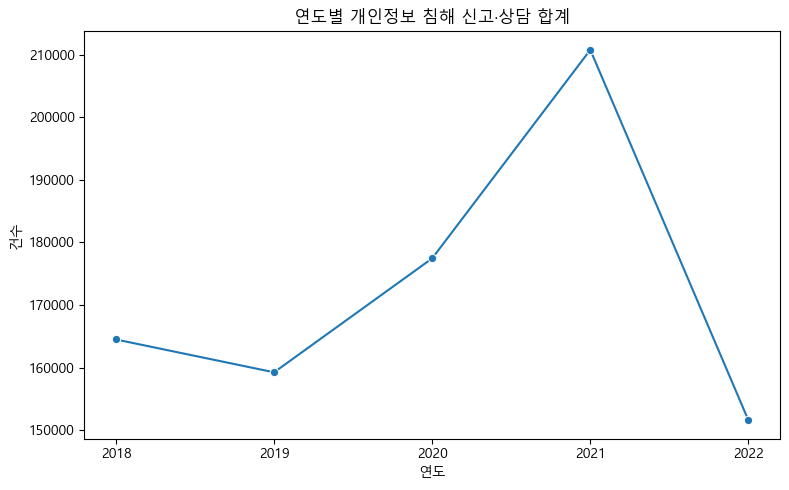

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

consult['year_num'] = consult['year'].str.replace('년', '', regex=False).astype(int)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=consult,
    x='year_num',
    y='total_count',
    marker='o'
)
plt.title("연도별 개인정보 침해 신고·상담 합계")
plt.xlabel("연도")
plt.ylabel("건수")
plt.xticks(consult['year_num'])
plt.tight_layout()
plt.savefig("figures/consult_year_total.png", dpi=150)
plt.show()


In [49]:
import pandas as pd

SERVICE_KEY = "e99cc7e40d66886c95fc0774b5fc67fad107a2898424b92960dda779f3c38413"

BASE_URL = "https://api.odcloud.kr/api/15140309/v1/uddi:b9866c18-eb6f-4158-8223-9ae1af3cbab9"

def fetch_corp_incident_table():
    """
    국내 민간 분야 침해사고 신고 건수 전체 표를
    Open API에서 JSON으로 받아 DataFrame으로 반환.
    """
    params = {
        "serviceKey": SERVICE_KEY, 
        "page": 1,                 
        "perPage": 100,              
    }
    resp = requests.get(BASE_URL, params=params, timeout=10)
    resp.raise_for_status()       
    data = resp.json()

    rows = data.get("data", [])
    df = pd.DataFrame(rows)
    return df

corp_raw = fetch_corp_incident_table()
corp_raw.head()


,2019년,2019년 상반기,2019년 하반기,2020년,2020년 상반기,2020년 하반기,2021년,2021년 상반기,2021년 하반기,2022년,2022년 상반기,2022년 하반기,2023년,2023년 상반기,2023년하반기,구분
0,418,238,180,603,291,312,640,298,342,1142,473,669,1277,664,613,신고 건수


In [35]:
corp_row = corp_raw[corp_raw['구분'] == '신고 건수'].iloc[0]

year_cols = [
    c for c in corp_raw.columns
    if ('년' in c) and ('상반기' not in c) and ('하반기' not in c)
]

corp_year = pd.DataFrame({
    "year": year_cols,
    "incident_count": [int(corp_row[c]) for c in year_cols]
})

corp_year["year_num"] = corp_year["year"].str.replace("년", "", regex=False).astype(int)

corp_agg = corp_year.copy()
corp_agg.head()


,year,incident_count,year_num
0,2019년,418,2019
1,2020년,603,2020
2,2021년,640,2021
3,2022년,1142,2022
4,2023년,1277,2023


In [36]:
consult['year_num'] = consult['year'].str.replace('년', '', regex=False).astype(int)
consult[['year', 'year_num', 'total_count']].head()


,year,year_num,total_count
0,2018년,2018,164497
1,2019년,2019,159255
2,2020년,2020,177457
3,2021년,2021,210767
4,2022년,2022,151603


   year_num  total_count  incident_count
0      2019       159255             418
1      2020       177457             603
2      2021       210767             640
3      2022       151603            1142


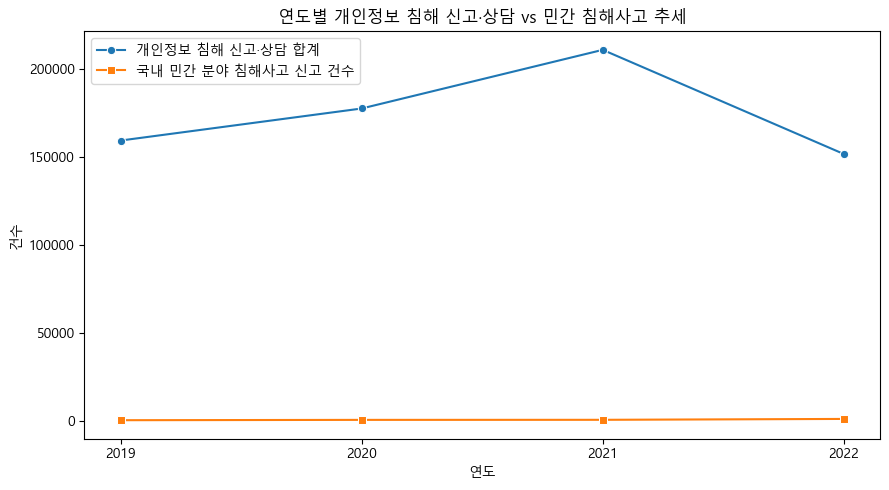

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

consult['year_num'] = consult['year'].astype(str).str.replace('년', '', regex=False).astype(int)

if 'year_num' not in corp_agg.columns:
    corp_agg['year_num'] = corp_agg['year'].astype(str).str.replace('년', '', regex=False).astype(int)

merged = pd.merge(
    consult[['year_num', 'total_count']],
    corp_agg[['year_num', 'incident_count']],
    on='year_num',
    how='inner'
)

print(merged)

plt.figure(figsize=(9, 5))

sns.lineplot(
    data=merged,
    x='year_num',
    y='total_count',
    marker='o',
    label='개인정보 침해 신고·상담 합계'
)

sns.lineplot(
    data=merged,
    x='year_num',
    y='incident_count',
    marker='s',
    label='국내 민간 분야 침해사고 신고 건수'
)

plt.title("연도별 개인정보 침해 신고·상담 vs 민간 침해사고 추세")
plt.xlabel("연도")
plt.ylabel("건수")
plt.xticks(merged['year_num'])
plt.legend()
plt.tight_layout()
plt.savefig("figures/consult_vs_corp_year_trend.png", dpi=150)
plt.show()


In [38]:
import requests
import pandas as pd

SERVICE_KEY = "e99cc7e40d66886c95fc0774b5fc67fad107a2898424b92960dda779f3c38413"

BASE_URL_RANSOM = "https://api.odcloud.kr/api/15140324/v1/uddi:8bb468da-5deb-4aa4-8d3d-b5cef29880a4" 

def fetch_ransomware_table():
    """
    국내 민간 분야 랜섬웨어 침해사고 신고 건수 전체 표를
    Open API에서 JSON으로 받아 DataFrame으로 반환.
    """
    params = {
        "serviceKey": SERVICE_KEY,
        "page": 1,
        "perPage": 100,  
    }

    resp = requests.get(BASE_URL_RANSOM, params=params, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    rows = data.get("data", [])
    df = pd.DataFrame(rows)
    return df

ransom_raw = fetch_ransomware_table()
ransom_raw.head()


,2019년,2019년 상반기,2019년 하반기,2020년,2020년 상반기,2020년 하반기,2021년,2021년 상반기,2021년 하반기,2022년,2022년 상반기,2022년 하반기,2023년,2023년 상반기,2023년하반기,구분
0,39,22,17,127,46,81,223,78,145,325,118,207,258,134,124,신고건수


In [39]:
print(ransom_raw)

ransom_row = ransom_raw.iloc[0]

year_cols_r = [
    c for c in ransom_raw.columns
    if ('년' in c) and ('상반기' not in c) and ('하반기' not in c)
]

ransom_year = pd.DataFrame({
    "year": year_cols_r,
    "ransom_count": [
        int(str(ransom_row[c]).replace(",", "").strip())
        for c in year_cols_r
    ]
})

ransom_year["year_num"] = (
    ransom_year["year"].str.replace("년", "", regex=False).astype(int)
)

ransom_agg = ransom_year.copy()
ransom_agg.head()


   2019년  2019년 상반기  2019년 하반기  2020년  2020년 상반기  2020년 하반기  2021년  2021년 상반기  \
0     39         22         17    127         46         81    223         78   

   2021년 하반기  2022년  2022년 상반기  2022년 하반기  2023년  2023년 상반기  2023년하반기    구분  
0        145    325        118        207    258        134       124  신고건수  


,year,ransom_count,year_num
0,2019년,39,2019
1,2020년,127,2020
2,2021년,223,2021
3,2022년,325,2022
4,2023년,258,2023


In [40]:
import pandas as pd

corp_ransom = pd.merge(
    corp_agg[['year_num', 'incident_count']],
    ransom_agg[['year_num', 'ransom_count']],
    on='year_num',
    how='inner'
)

# 랜섬웨어 비중(%)
corp_ransom['ransom_ratio'] = (
    corp_ransom['ransom_count'] / corp_ransom['incident_count'] * 100
)

corp_ransom


,year_num,incident_count,ransom_count,ransom_ratio
0,2019,418,39,9.330144
1,2020,603,127,21.061360
2,2021,640,223,34.843750
3,2022,1142,325,28.458844
4,2023,1277,258,20.203602


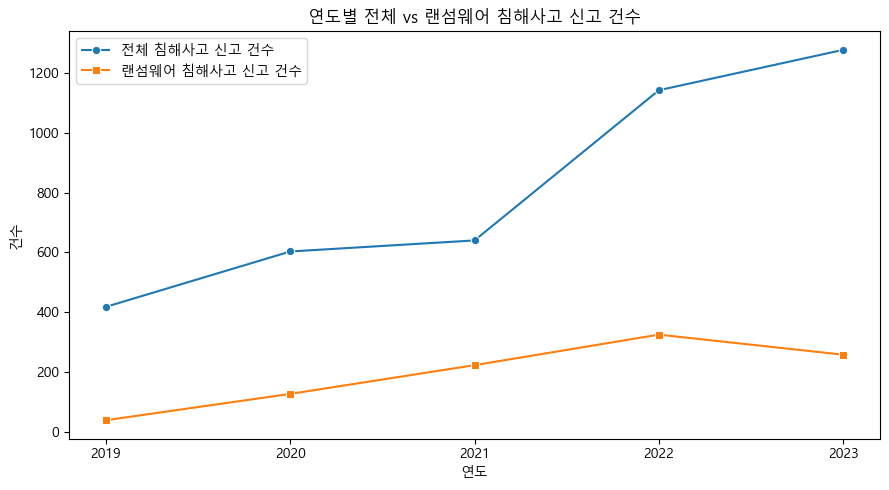

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))

sns.lineplot(
    data=corp_ransom,
    x='year_num',
    y='incident_count',
    marker='o',
    label='전체 침해사고 신고 건수'
)
sns.lineplot(
    data=corp_ransom,
    x='year_num',
    y='ransom_count',
    marker='s',
    label='랜섬웨어 침해사고 신고 건수'
)

plt.title("연도별 전체 vs 랜섬웨어 침해사고 신고 건수")
plt.xlabel("연도")
plt.ylabel("건수")
plt.xticks(corp_ransom['year_num'])
plt.legend()
plt.tight_layout()
plt.savefig("figures/corp_vs_ransom_year_trend.png", dpi=150)
plt.show()


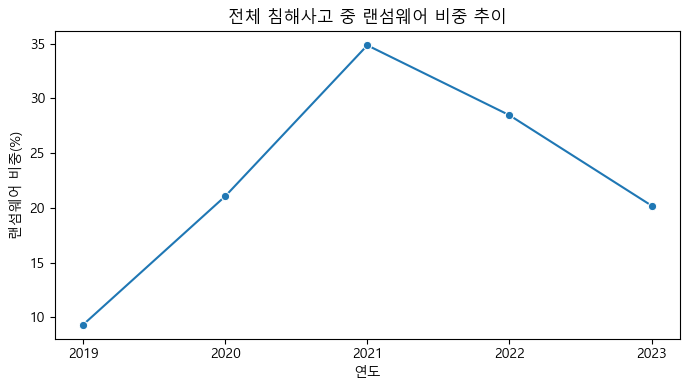

In [42]:
plt.figure(figsize=(7,4))
sns.lineplot(
    data=corp_ransom,
    x='year_num',
    y='ransom_ratio',
    marker='o'
)
plt.title("전체 침해사고 중 랜섬웨어 비중 추이")
plt.xlabel("연도")
plt.ylabel("랜섬웨어 비중(%)")
plt.xticks(corp_ransom['year_num'])
plt.tight_layout()
plt.savefig("figures/ransom_ratio_trend.png", dpi=150)
plt.show()


In [52]:
import requests
import pandas as pd

SERVICE_KEY = "e99cc7e40d66886c95fc0774b5fc67fad107a2898424b92960dda779f3c38413"

BASE_URL_SIZE = "https://api.odcloud.kr/api/15140334/v1/uddi:6f822e3a-ae9a-447a-b1ae-fe2ed1bcb5a2"

def fetch_size_table():
    """
    국내 민간 분야 기업 규모별 침해사고 신고 건수 전체 표를
    Open API에서 JSON으로 받아 DataFrame으로 반환.
    """
    params = {
        "serviceKey": SERVICE_KEY,
        "page": 1,
        "perPage": 100,
    }

    resp = requests.get(BASE_URL_SIZE, params=params, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    rows = data.get("data", [])
    df = pd.DataFrame(rows)
    return df

size_raw = fetch_size_table()
size_raw.head()


,2019년,2020년,2021년,2022년,2023년,구분
0,10,23,20,31,54,대기업
1,23,27,62,78,120,중견기업
2,363,495,518,954,1034,중소기업
3,22,58,40,79,69,비영리


In [53]:
print(size_raw)

sm_row = size_raw[size_raw['구분'] == '중소기업'].iloc[0]

year_cols_s = [
    c for c in size_raw.columns
    if ('년' in c) and ('상반기' not in c) and ('하반기' not in c)
]

size_year = pd.DataFrame({
    "year": year_cols_s,
    "sm_incident": [
        int(str(sm_row[c]).replace(",", "").strip())
        for c in year_cols_s
    ]
})

size_year["year_num"] = (
    size_year["year"].str.replace("년", "", regex=False).astype(int)
)

size_agg = size_year.copy()
size_agg.head()


   2019년  2020년  2021년  2022년  2023년    구분
0     10     23     20     31     54   대기업
1     23     27     62     78    120  중견기업
2    363    495    518    954   1034  중소기업
3     22     58     40     79     69   비영리


,year,sm_incident,year_num
0,2019년,363,2019
1,2020년,495,2020
2,2021년,518,2021
3,2022년,954,2022
4,2023년,1034,2023


   year_num  incident_count  sm_incident   sm_ratio
0      2019             418          363  86.842105
1      2020             603          495  82.089552
2      2021             640          518  80.937500
3      2022            1142          954  83.537653
4      2023            1277         1034  80.971026


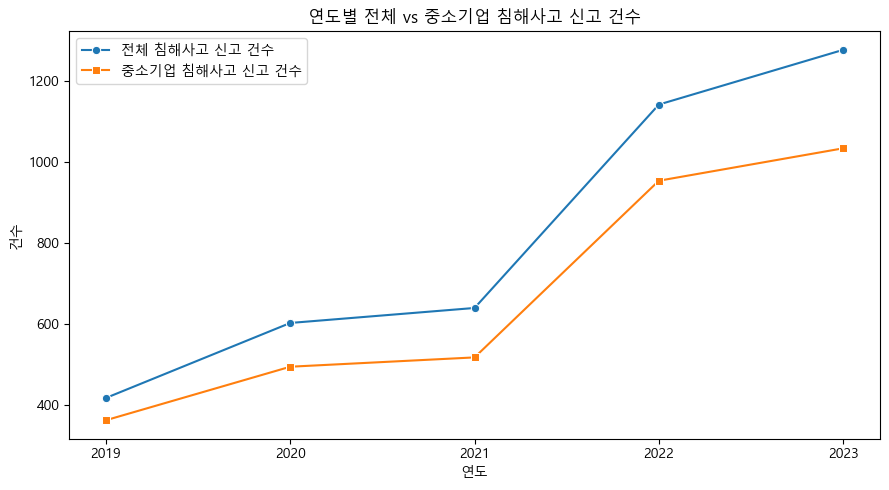

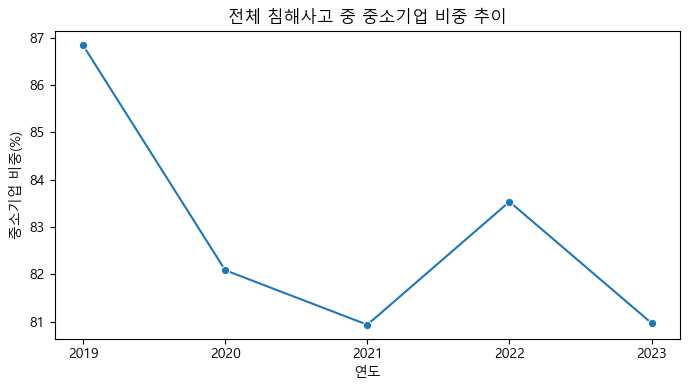

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

corp_size = pd.merge(
    corp_agg[['year_num', 'incident_count']],
    size_agg[['year_num', 'sm_incident']],
    on='year_num',
    how='inner'
)

corp_size['sm_ratio'] = (
    corp_size['sm_incident'] / corp_size['incident_count'] * 100
)

print(corp_size)

plt.figure(figsize=(9,5))
sns.lineplot(data=corp_size, x='year_num', y='incident_count',
             marker='o', label='전체 침해사고 신고 건수')
sns.lineplot(data=corp_size, x='year_num', y='sm_incident',
             marker='s', label='중소기업 침해사고 신고 건수')
plt.title("연도별 전체 vs 중소기업 침해사고 신고 건수")
plt.xlabel("연도")
plt.ylabel("건수")
plt.xticks(corp_size['year_num'])
plt.legend()
plt.tight_layout()
plt.savefig("figures/corp_vs_sme_year_trend.png", dpi=150)
plt.show()

plt.figure(figsize=(7,4))
sns.lineplot(data=corp_size, x='year_num', y='sm_ratio',
             marker='o')
plt.title("전체 침해사고 중 중소기업 비중 추이")
plt.xlabel("연도")
plt.ylabel("중소기업 비중(%)")
plt.xticks(corp_size['year_num'])
plt.tight_layout()
plt.savefig("figures/sme_ratio_trend.png", dpi=150)
plt.show()


In [55]:
import pandas as pd

exp_type = pd.read_csv("exp_type_leak_theft_year.csv")

# 필요 컬럼만 정리
corp_core = corp_agg[['year_num', 'incident_count']].copy()
ransom_core = ransom_agg[['year_num', 'ransom_count']].copy()

merged_all = (
    corp_core
    .merge(ransom_core, on='year_num', how='left')
    .merge(corp_size[['year_num', 'sm_incident', 'sm_ratio']], on='year_num', how='left')
    .merge(exp_type, on='year_num', how='left')
    .sort_values('year_num')
)

merged_all


,year_num,incident_count,ransom_count,sm_incident,sm_ratio,leak_rate,theft_rate
0,2019,418,39,363,86.842105,21.8,6.5
1,2020,603,127,495,82.089552,28.0,11.6
2,2021,640,223,518,80.937500,24.8,12.7
3,2022,1142,325,954,83.537653,NaN,NaN
4,2023,1277,258,1034,80.971026,NaN,NaN


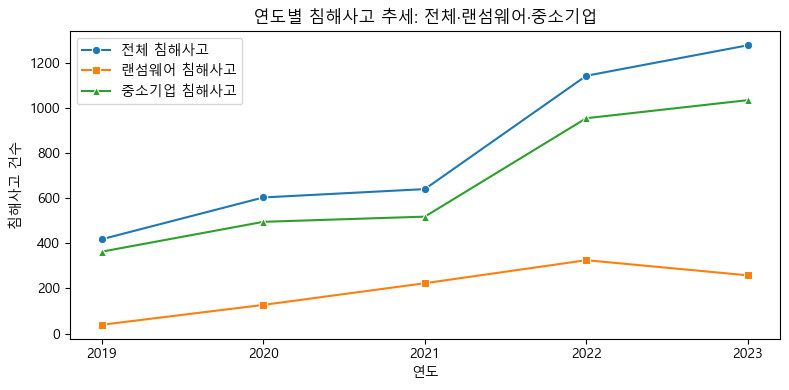

In [56]:
plt.figure(figsize=(8,4))
sns.lineplot(data=merged_all, x='year_num', y='incident_count',
             marker='o', label='전체 침해사고')
sns.lineplot(data=merged_all, x='year_num', y='ransom_count',
             marker='s', label='랜섬웨어 침해사고')
sns.lineplot(data=merged_all, x='year_num', y='sm_incident',
             marker='^', label='중소기업 침해사고')

plt.title("연도별 침해사고 추세: 전체·랜섬웨어·중소기업")
plt.xlabel("연도")
plt.ylabel("침해사고 건수")
plt.xticks(merged_all['year_num'])
plt.legend()
plt.tight_layout()
plt.savefig("figures/corp_only_trend.png", dpi=150)
plt.show()


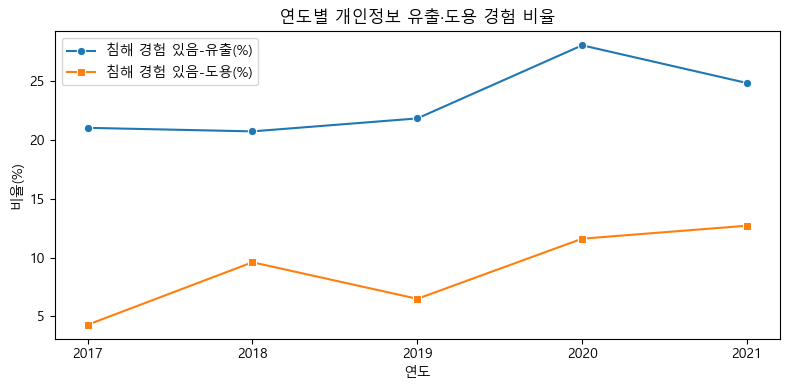

In [48]:
plt.figure(figsize=(8,4))
sns.lineplot(data=exp_type, x='year_num', y='leak_rate',
             marker='o', label='침해 경험 있음-유출(%)')
sns.lineplot(data=exp_type, x='year_num', y='theft_rate',
             marker='s', label='침해 경험 있음-도용(%)')

plt.title("연도별 개인정보 유출·도용 경험 비율")
plt.xlabel("연도")
plt.ylabel("비율(%)")
plt.xticks(exp_type['year_num'])
plt.legend()
plt.tight_layout()
plt.savefig("figures/exp_only_trend.png", dpi=150)
plt.show()
